<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment2/MachineLearningAssignment2SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading libraries and Data in

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import files
uploaded = files.upload()
data = pd.read_csv('Sentiment140.tenPercent.sample.tweets.tsv', sep='\t', delimiter=None, header='infer', names=None, index_col=None)

Saving Sentiment140.tenPercent.sample.tweets.tsv to Sentiment140.tenPercent.sample.tweets.tsv


# Data Exploration

Check Size of Data

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   sentiment_label  160000 non-null  int64 
 1   tweet_text       160000 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


Check if any missing values

In [4]:
print(data.isnull().values.any())

False


Rename sentiment_label to target and drop duplicates

In [5]:
df = data.copy()
df.rename(columns = {'sentiment_label':'target'}, inplace = True)

print("Number of duplicates before dropping:  " + str(len(df[df.duplicated()])))

df.drop_duplicates(keep = False, inplace = True)
print("Number of duplicates after dropping:  " + str(len(df[df.duplicated()])))

Number of duplicates before dropping:  553
Number of duplicates after dropping:  0


Checking if data balanced

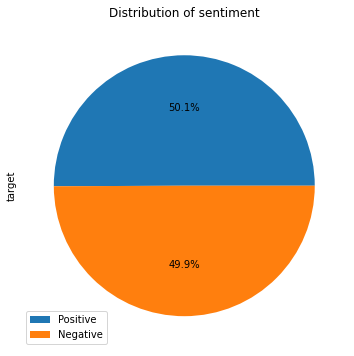

In [6]:
df['target'] = df['target'].replace(4,1)

df['target'].value_counts().plot.pie(figsize=(6,6),title="Distribution of sentiment",labels=['',''],autopct='%1.1f%%')
labels=["Positive","Negative"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')

Generate word cloud

Creating word clouds...


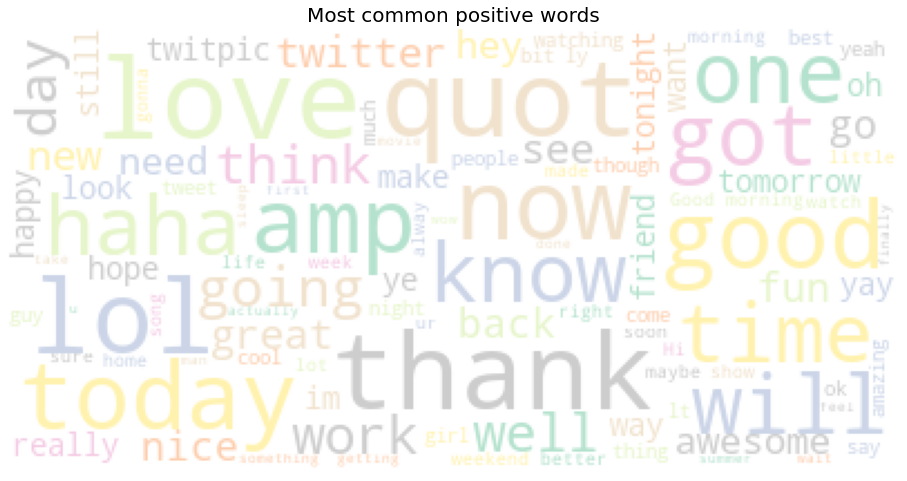

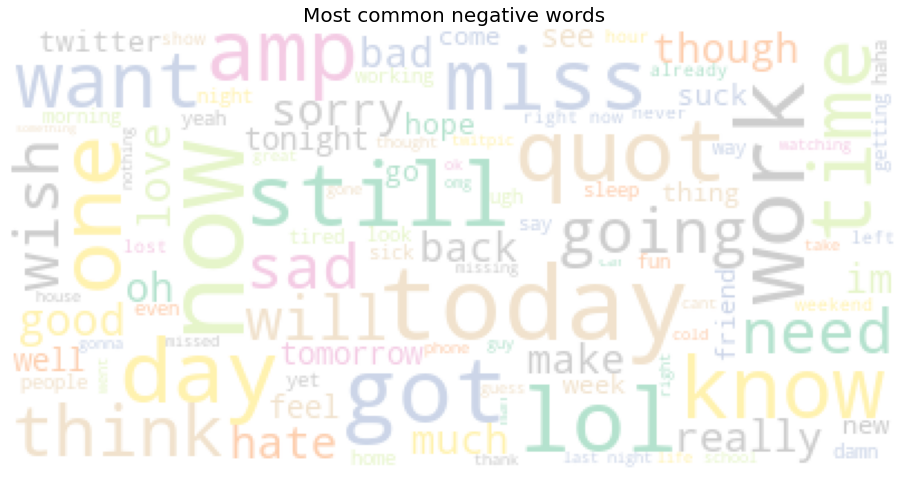

In [7]:
from wordcloud import WordCloud
from collections import Counter

def generate_wordcloud(words,sentiment):
    plt.figure(figsize=(16,13))
    wc = WordCloud(background_color="white", max_words=100, max_font_size=50)
    wc.generate(words)
    plt.title("Most common {} words".format(sentiment), fontsize=20)
    plt.imshow(wc.recolor(colormap='Pastel2', random_state=17), alpha=0.98)
    plt.axis('off')

print("Creating word clouds...")
positive_words=" ".join(df[df.target==1]['tweet_text'].values)
negative_words=" ".join(df[df.target==0]['tweet_text'].values)

generate_wordcloud(positive_words,"positive")
generate_wordcloud(negative_words,"negative")


# Data Pre-processing

In [18]:
dataset = df.copy()

In [19]:
print(dataset['tweet_text'].head(20))

0                                                                    @elephantbird Hey dear, Happy Friday to You  Already had your rice's bowl for lunch ?
1                                                                                               Ughhh layin downnnn    Waiting for zeina to cook breakfast
2                                     @greeniebach I reckon he'll play, even if he's not 100%...but i know nothing!! ;) It won't be the same without him. 
3                                                                                                                    @vaLewee I know!  Saw it on the news!
4                                   very sad that http://www.fabchannel.com/ has closed down. One of the few web services that I've used for over 5 years 
5                                                          @Fearnecotton who sings 'I Remember'? i alwaysss hear it on Radio 1 but never catch the artist 
6                                                                     

Check which tweets over 140 char

In [20]:
dataset['pre_clean_len'] = [len(t) for t in dataset.tweet_text]
dataset[dataset.pre_clean_len > 140].head(10)

,target,tweet_text,pre_clean_len
19,0,@danielak Who will say &quot;Good Morning&quot; when I head to bed over the next month Seriously have a marvelous time &amp; check in when you can!,148
360,0,is hurt that she has to miss coco and linsey's sleepover because her parents dragged her to spend &quot;quality time&quot; with them on the yacht.,147
383,0,Shit with dis! I go to bed at what 6 &amp; put alarm to wake up at 9. i wake up at 9 but then fall asleep again and wake at 1pm buhuu. Sucks,141
501,1,@Lisa_Veronica @jessicaveronica i really cant express how much you girls made me happy on 23rd may http://bit.ly/qeufC &lt;3 &lt;3 &lt;3 &lt;3 &lt;3 &lt;3,155
542,0,"why does every band i &lt;3 evolve into bands that i dont &lt;3 bullet for my valentine, underoath, avenged 7x, in flames, and now alexisonfire",144
561,0,@Larissa_SG yes yes i have a few but they are blury ahh he was soo cute! he said LECHUGA=lettuce he said fiesta too &lt;3 it was amazing! &gt;3,144
654,0,"it is this process that we are told is broken in Turkish locale - string.Compare(&quot;INSTALL&quot;, &quot;install&quot;, true) != 0 but can't repro",150
792,0,"@jicasiano Well, I am mature, but I also thrive on the physical connection. I've had a long distance relationship before &amp; it wasn't fun",141
1047,0,"WTF @ selenagomez AHHH i didn't know you were gonna be on the early show today OHman ILove you anyway , &amp; u bettah than all these Hoes",141
1414,1,"Getting ready to start my day! Cleaning the house, caring for 2 small kids, &amp; preparing for my Madison Party tomorrow! The life of a mom",141


  Convert HTML Encoding



In [21]:
import html
def remove_html_encoding(text):
    return html.unescape(text)
dataset['tweet_text']= dataset['tweet_text'].apply(lambda x: remove_html_encoding(x))

Convert to lower case

In [22]:
dataset['tweet_text']=dataset['tweet_text'].str.lower()
print(dataset['tweet_text'].head())

0                                     @elephantbird hey dear, happy friday to you  already had your rice's bowl for lunch ?
1                                                                ughhh layin downnnn    waiting for zeina to cook breakfast
2      @greeniebach i reckon he'll play, even if he's not 100%...but i know nothing!! ;) it won't be the same without him. 
3                                                                                     @valewee i know!  saw it on the news!
4    very sad that http://www.fabchannel.com/ has closed down. one of the few web services that i've used for over 5 years 
Name: tweet_text, dtype: object


Convert emoticons to words

In [23]:
emoticons = [   ('SMILEY',   [':-)', ':)', '(:', '(-:', ] )  ,
    ('laugh',        [':-D', ':D', 'X-D', 'XD', 'xD', ] )    ,
    ('love',     ['<3', ':\*', ] )   ,
    ('cheeky',     ['=p'] )   ,
    ('wink',     [';-)',';)', ';-D', ';D', '(;', '(-;', ] ) ,
    ('frown',        [':-(', ':(', '(:', '(-:', ] )  ,
    ('cry',      [':,(', ':\'(', ':"(', ':(('] ) ,
]

def convert_emoticons(msg):
  for emote, replacement in emoticons:
     for symbol in replacement:
         msg = msg.replace(symbol,emote)
  return msg

dataset['tweet_text']= dataset['tweet_text'].apply(lambda x: convert_emoticons(x))

Remove twitter handles

In [24]:
def remove_handles(text):
    return re.sub("@[A-Za-z0-9]+", r'', text)
dataset['tweet_text']= dataset['tweet_text'].apply(lambda x: remove_handles(x))
print(dataset['tweet_text'].head(50))

0                                                                     hey dear, happy friday to you  already had your rice's bowl for lunch ?
1                                                                                  ughhh layin downnnn    waiting for zeina to cook breakfast
2                                   i reckon he'll play, even if he's not 100%...but i know nothing!! wink it won't be the same without him. 
3                                                                                                                i know!  saw it on the news!
4                      very sad that http://www.fabchannel.com/ has closed down. one of the few web services that i've used for over 5 years 
5                                                           who sings 'i remember'? i alwaysss hear it on radio 1 but never catch the artist 
6                                                                                               with god on ur side anything is possible.... 
7     

Remove urls

In [25]:
def cleaning_URLs(data):
    return re.sub('http\S+|www.\S+',' ',data)
dataset['tweet_text'] = dataset['tweet_text'].apply(lambda x: cleaning_URLs(x))
print(dataset['tweet_text'].head(10))

0                                                                    hey dear, happy friday to you  already had your rice's bowl for lunch ?
1                                                                                 ughhh layin downnnn    waiting for zeina to cook breakfast
2                                  i reckon he'll play, even if he's not 100%...but i know nothing!! wink it won't be the same without him. 
3                                                                                                               i know!  saw it on the news!
4                                              very sad that   has closed down. one of the few web services that i've used for over 5 years 
5                                                          who sings 'i remember'? i alwaysss hear it on radio 1 but never catch the artist 
6                                                                                              with god on ur side anything is possible.... 
7            

Remove numbers

In [26]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['tweet_text'] = dataset['tweet_text'].apply(lambda x: cleaning_numbers(x))
print(dataset['tweet_text'].head(10))

0                                                                    hey dear, happy friday to you  already had your rice's bowl for lunch ?
1                                                                                 ughhh layin downnnn    waiting for zeina to cook breakfast
2                                     i reckon he'll play, even if he's not %...but i know nothing!! wink it won't be the same without him. 
3                                                                                                               i know!  saw it on the news!
4                                               very sad that   has closed down. one of the few web services that i've used for over  years 
5                                                           who sings 'i remember'? i alwaysss hear it on radio  but never catch the artist 
6                                                                                              with god on ur side anything is possible.... 
7            

Removes apostrophes and quotes

In [27]:
def cleaning_apostrophes(data):
    return re.sub("(?<=[a-z])'(?=[a-z])", "", data)

def cleaning_quotes(data):
    return re.sub(r'\'', '', data)

dataset['tweet_text'] = dataset['tweet_text'].apply(lambda x: cleaning_apostrophes(x))
dataset['tweet_text'] = dataset['tweet_text'].apply(lambda x: cleaning_quotes(x))

print(dataset['tweet_text'].head(30))

0                                                                      hey dear, happy friday to you  already had your rices bowl for lunch ?
1                                                                                  ughhh layin downnnn    waiting for zeina to cook breakfast
2                                         i reckon hell play, even if hes not %...but i know nothing!! wink it wont be the same without him. 
3                                                                                                                i know!  saw it on the news!
4                                                 very sad that   has closed down. one of the few web services that ive used for over  years 
5                                                              who sings i remember? i alwaysss hear it on radio  but never catch the artist 
6                                                                                               with god on ur side anything is possible.... 
7     

Tokenise

In [28]:
from nltk.tokenize import sent_tokenize, word_tokenize 

dataset['tweet_text'] = dataset['tweet_text'].apply(word_tokenize)
print(dataset['tweet_text'].head(10))

0                                                                                    [hey, dear, ,, happy, friday, to, you, already, had, your, rices, bowl, for, lunch, ?]
1                                                                                                         [ughhh, layin, downnnn, waiting, for, zeina, to, cook, breakfast]
2                                       [i, reckon, hell, play, ,, even, if, hes, not, %, ..., but, i, know, nothing, !, !, wink, it, wont, be, the, same, without, him, .]
3                                                                                                                                   [i, know, !, saw, it, on, the, news, !]
4                                                              [very, sad, that, has, closed, down, ., one, of, the, few, web, services, that, ive, used, for, over, years]
5                                                                            [who, sings, i, remember, ?, i, alwaysss, hear, it, on, radio, 

Stem

In [29]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['tweet_text']= dataset['tweet_text'].apply(lambda x: stemming_on_text(x))
print(dataset['tweet_text'].head(10))

0                                                                                    [hey, dear, ,, happy, friday, to, you, already, had, your, rices, bowl, for, lunch, ?]
1                                                                                                         [ughhh, layin, downnnn, waiting, for, zeina, to, cook, breakfast]
2                                       [i, reckon, hell, play, ,, even, if, hes, not, %, ..., but, i, know, nothing, !, !, wink, it, wont, be, the, same, without, him, .]
3                                                                                                                                   [i, know, !, saw, it, on, the, news, !]
4                                                              [very, sad, that, has, closed, down, ., one, of, the, few, web, services, that, ive, used, for, over, years]
5                                                                            [who, sings, i, remember, ?, i, alwaysss, hear, it, on, radio, 

Lemmatize

In [30]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['tweet_text'] = dataset['tweet_text'].apply(lambda x: lemmatizer_on_text(x))
print(dataset['tweet_text'].head(10))

0                                                                                    [hey, dear, ,, happy, friday, to, you, already, had, your, rices, bowl, for, lunch, ?]
1                                                                                                         [ughhh, layin, downnnn, waiting, for, zeina, to, cook, breakfast]
2                                       [i, reckon, hell, play, ,, even, if, hes, not, %, ..., but, i, know, nothing, !, !, wink, it, wont, be, the, same, without, him, .]
3                                                                                                                                   [i, know, !, saw, it, on, the, news, !]
4                                                              [very, sad, that, has, closed, down, ., one, of, the, few, web, services, that, ive, used, for, over, years]
5                                                                            [who, sings, i, remember, ?, i, alwaysss, hear, it, on, radio, 

De-tokenise after stemming and lemmatizing

In [32]:
import re
from nltk.tokenize.treebank import TreebankWordDetokenizer as Detok
detokenizer = Detok()

dataset['tweet_text_untokenised'] = dataset.tweet_text.apply(lambda row: detokenizer.detokenize(row))
print(dataset['tweet_text_untokenised'].head(20))

0                                                                       hey dear, happy friday to you already had your rices bowl for lunch?
1                                                                                    ughhh layin downnnn waiting for zeina to cook breakfast
2                                          i reckon hell play, even if hes not%...but i know nothing!! wink it wont be the same without him.
3                                                                                                                i know! saw it on the news!
4                                                   very sad that has closed down . one of the few web services that ive used for over years
5                                                               who sings i remember? i alwaysss hear it on radio but never catch the artist
6                                                                                               with god on ur side anything is possible....
7            

# Machine Learning

In [33]:
X=dataset.tweet_text_untokenised
y=dataset.target

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state =0)

Turn Sentences into numerica data

In [35]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=700000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  634984


In [36]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [38]:
models = {}

from sklearn.linear_model import LogisticRegression
models['BernoulliNB'] = BernoulliNB(alpha=1)
models['Logistic Regression'] = LogisticRegression(C = 1,solver ='sag')

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall, predictions = {}, {}, {}, {}

for key in models.keys():
    
    # Fit the classifier model
    models[key].fit(X_train, y_train)
    # Prediction 
    predictions[key] = models[key].predict(X_test)
    
    # Calculate Accuracy, Precision and Recall Metrics
    accuracy[key] = accuracy_score(predictions[key], y_test)
    precision[key] = precision_score(predictions[key], y_test)
    recall[key] = recall_score(predictions[key], y_test)

# Evaluation

Show Accuracy, Precision & Recall

                     Accuracy  Precision    Recall
BernoulliNB          0.783650   0.809500  0.772241
Logistic Regression  0.803066   0.797282  0.809186


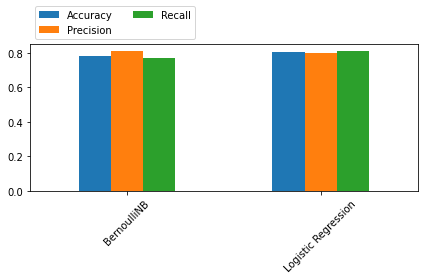

In [47]:
import pandas as pd

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

print(df_model)

ax  = df_model.plot.bar(rot=45)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 10})
plt.tight_layout()

Plot Correlation Matrices

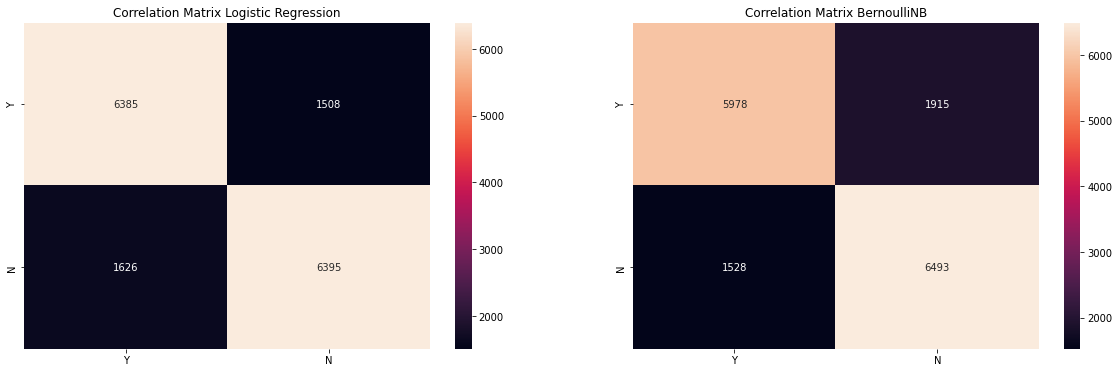

In [43]:
from sklearn.metrics import confusion_matrix

def get_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  return cm

def plot_cm(ax,labels, predictions,title, p=0.5):
  tick_labels = ['Y', 'N']
  cm = get_cm(labels, predictions, p)
  sns.heatmap(cm, annot=True, fmt="d",ax=ax)
  ax.title.set_text(title)
  ax.set_xticklabels(tick_labels)
  ax.set_yticklabels(tick_labels)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,6))
plot_cm(ax1,y_test, predictions['Logistic Regression'],"Correlation Matrix Logistic Regression")
plot_cm(ax2,y_test, predictions['BernoulliNB'],"Correlation Matrix BernoulliNB")

Plot ROC Curves

In [44]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(ax,labels, predictions,title):
  fpr, tpr, thresholds = roc_curve(labels, predictions)
  roc_auc = auc(fpr, tpr)
  ax.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.legend(loc="lower right")
  ax.title.set_text(title)

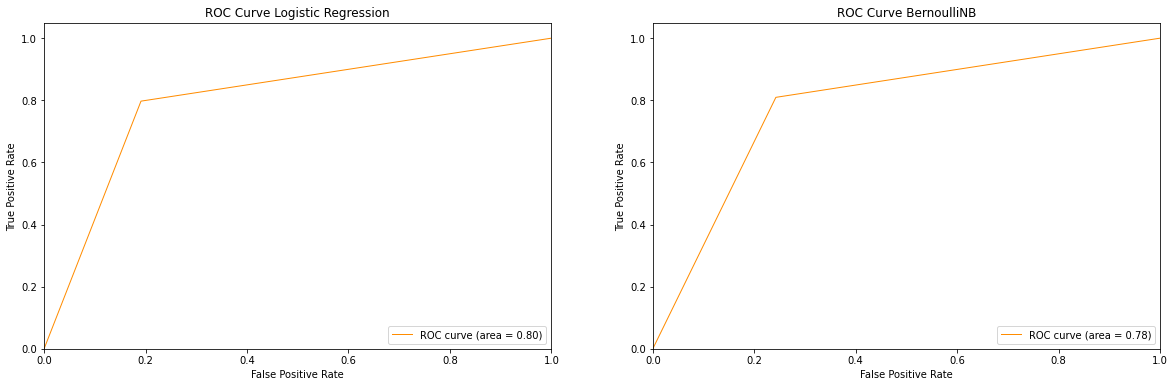

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,6))
plot_roc_curve(ax1, y_test, predictions['Logistic Regression'],"ROC Curve Logistic Regression")
plot_roc_curve(ax2, y_test, predictions['BernoulliNB'],"ROC Curve BernoulliNB")

# Hyper-Parameter Tuning

Hyper-parameter tunign logistic regression

In [ ]:
logistic = LogisticRegression()
print(logistic.get_params().keys())

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])


In [ ]:
from sklearn.model_selection import GridSearchCV

C = [0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
solver = ['liblinear', 'saga',"sag"]
hyperparameters = dict(C=C, solver=solver)

logistic = LogisticRegression()

gridsearch = GridSearchCV(estimator=logistic, param_grid=hyperparameters,verbose=True)
best_model_grid_search = gridsearch.fit(X_train, y_train)
print(best_model_grid_search.best_estimator_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
LogisticRegression(C=1, solver='sag')


Hyper-parameter tuning bernoulliNB

In [ ]:
print(bernoulliNB.get_params().keys())

dict_keys(['alpha', 'binarize', 'class_prior', 'fit_prior'])


In [ ]:
from sklearn.model_selection import GridSearchCV

alpha = [0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
hyperparameters = dict(alpha = alpha)

bernoulliNB = BernoulliNB()

gridsearch = GridSearchCV(estimator=bernoulliNB, param_grid=hyperparameters,verbose=True)
best_model_grid_search = gridsearch.fit(X_train, y_train)
print(best_model_grid_search.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
BernoulliNB(alpha=1)
